In [1]:
import os
import itertools
import random
from math import log, exp, sqrt

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler


import matplotlib.animation as animation

import numpy as np
from scipy import stats
from numpy.linalg import norm

import ars

from BayesW_utils import *
from distributions import *

In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black', 'blue', 'green'])))#, )))

# Sampling algorithm

## Init functions

In [20]:
n_markers, n_samples,n_covs = 150,100,10

In [4]:
def simulate_data(mu_true, alpha_true, sigma_g_true, n_markers, n_samples, n_covs, prevalence):
    '''
    Function to simulate markers and phenotype, given the parameters.
    
    Input:
    - mu_true: intercept 
    - alpha_true: alpha 
    - sigma_g_true: true sigma_g value.
    - n_markers: number of markers
    - n_samples: number of samples
    - n_covs: number of covariates
    - prevalence: prevalence of the phenotype (how many people have had the event)

    Output:
    - markers: simulated marker data as a numpy array
    - betas: simulated beta coefficients as a numpy array
    - cov: simulated covariate data as a numpy array.
    - d_fail: simulated failure indicator (1: event ocurred, 0: it didnt) 
    - log_data: log phenotype data

    '''
    ## log Yi = mu + xB + wi/alpha + K/alpha

    ## Draw the errors from a standard Gumbel(wi)
    gumbel_dis = stats.gumbel_r(loc=0, scale=1)
    w = gumbel_dis.rvs(size=(n_samples,1))

    ## genetic effects
    betas = np.random.normal(0, np.sqrt(sigma_g_true/n_markers), size = (n_markers, 1))
    markers = np.random.binomial(2, 0.5, (n_samples, n_markers))

    g = helpers.normalize_markers(markers).dot(betas)

    cov = np.random.binomial(1, 0.5, size = (n_samples, n_covs)) #z matrix of 

    ## failure indicator vector
    d_fail = np.random.choice([0,1], p=[1-prevalence, prevalence],size = n_samples)

    log_data = mu_true + g + w/alpha_true + np.euler_gamma/alpha_true
    log_data = log_data.reshape(log_data.shape[0])

    return (markers, betas, cov, d_fail, log_data)

In [8]:
def init_parameters(n_markers, l_mix, data):
    '''
    Function to initilize the parameters dictionary
    
    Input: 
    - n_markers: number of markers
    - l_mix: number of mixture components
    - data: the simulated data

    Output:
    - pars: dictionary with all the paremeters
    - alpha_ini: the initial value of alpha
    - sigma_ini: the initial value of sigma
    
    '''
    markers, _, _, d_fail, y_data_log= data

    mu = np.mean(y_data_log)
    #alpha_ini = np.var(y_data_log)
    alpha_ini = np.pi/np.sqrt( 6 * np.sum( (y_data_log-mu) **2) / (len(y_data_log)-1))
    sigma_g_ini = np.pi**2/(6* n_markers * alpha_ini**2)
    norm_markers = helpers.normalize_markers(markers)
    pi_L = np.zeros(l_mix)
    pi_L[0] = 0.99
    pi_L[1:] = (1 - pi_L[0])/(l_mix - 1)
    
    pars = {"alpha": alpha_ini, 
            "sigma_g": sigma_g_ini,
            "d": np.sum(d_fail), 
            "mu": mu,
            "var_mu": 100, 
            "var_delta": 100,
            
            "alpha_zero": 0.01,
            "kappa_zero": 0.01,

            "d_array": d_fail,

            "alpha_sigma": 1,
            "beta_sigma": 0.0001,

            "n_markers": n_markers,
            

            # "mixture_Ck_all": np.ones(n_markers)*0.01/n_markers,
            # "mixture_groups": 1,
            "mixture_component": np.zeros(n_markers),
            
            "v": np.zeros(l_mix),

            "sum_fail_all": (d_fail * norm_markers.T).sum(axis=1),
            "mean_sd_ratio_all": np.mean(markers, axis=0)/np.std(markers, axis=0),
            "sd_all": np.std(markers, axis=0),


            "Ck": [0.001, 0.0001, 0.00001 ],
            "l_mix": l_mix,
            "pi_L": pi_L,
            "marginal_likelihoods": np.ones(l_mix),

            "hyperparameters": np.zeros(l_mix +1),
            "gammas": np.zeros(n_markers),

    }
    
    return pars, alpha_ini, sigma_g_ini

First we simulate the markers, the betas, the covariates (not used at all), the failure indicator and the phenotype.

In [21]:
mu_true = 4
alpha_true = 10
sigma_g_true = np.pi**2/(6*alpha_true**2) ## sigma_g variable equals the sigma_g squared parameter

data = simulate_data(mu_true = mu_true, 
                     alpha_true = alpha_true, 
                     sigma_g_true = sigma_g_true,
                     n_markers = n_markers,
                     n_samples = n_samples,
                     n_covs = n_covs,
                     prevalence = 1
                     )
markers, betas, cov, d_fail, y_data_log = data

In [22]:
norm_markers = helpers.normalize_markers(markers)

The normalize_markers function from helpers:

In [36]:
def normalize_markers(markers):
    return (markers - markers.mean(axis=0))/markers.std(axis=0)

In [23]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                l_mix = 4, 
                                                data = data)

### Variance check up

From the supp material of the paper:

$$ Var(\log Y_i) = \sigma_G^2 + \frac{\pi^2}{6\alpha^2} $$

In [27]:
print("Sample variance: ",np.var(y_data_log))
print("Phenotypic variance: ",sigma_g_true + np.pi**2/(6*alpha_true**2))

Sample variance:  0.03766099772438017
Phenotypic variance:  0.032898681336964525


Init values for alpha and sigma:

$$ \alpha = \frac{\pi}{\sqrt{\frac{6\sum (Y_i - \mu)^2}{N-1}}} $$

$$ \sigma_G^2 = \frac{\pi^2}{\alpha^2} $$

L are the mixture components and N the sample size

In [28]:
pars["alpha"], pars["sigma_g"]

(6.575759698499429, 0.0002536094122853883)

In [40]:
epsilon = y_data_log

### mu density checkup

In [36]:
def log_mu(pars, epsilon_arr):
    '''computes the log-likelihood of the mu parameter'''
    # this term is added so we can exponentiate the function
    return lambda x : (pars['alpha']*pars['mu']*pars['d'] -pars['alpha']*x*pars['d'] - \
                       np.sum(np.exp((epsilon_arr - x)*pars['alpha'] -np.euler_gamma)) \
                        - (x**2)/(2*pars["var_mu"]))


Text(0.5, 1.0, 'exp')

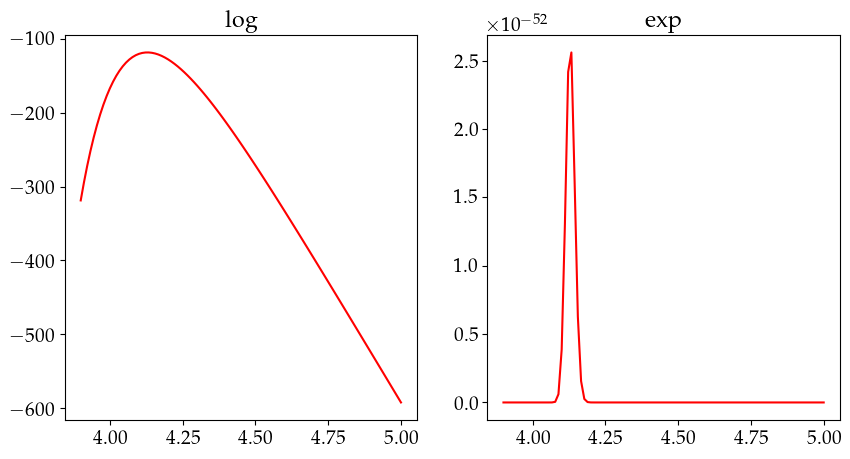

In [41]:
plt.figure(figsize=(10,5))
xplot = np.linspace(3.9,5,100)
plt.subplot(1,2,1)
f = [log_mu(pars, epsilon)(x) for x in xplot]
plt.plot(xplot,f)
plt.title('log')
plt.subplot(1,2,2)
plt.plot(xplot,np.exp(f))
plt.title('exp')

It is centered approximately around the true mean (4)

## alpha density

First form the data we remove the true intercept and genetic effects

In [44]:
epsilon = y_data_log - mu_true - norm_markers.dot(betas).reshape((n_samples,))

We have that 

$$Var(log Yi|\mu, \beta ...) = \frac{\pi^2}{6\alpha^2}$$

In [47]:
print(r"alpha = ", np.sqrt(np.pi**2/(6*epsilon.var())))

alpha =  11.882290408628469


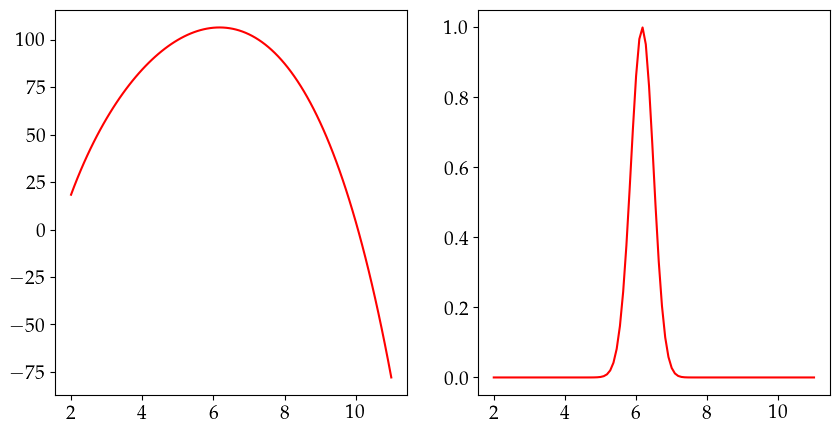

In [49]:
plt.figure(figsize=(10,5))
xplot = np.linspace(2,11,100)
f = [log_alpha(pars, epsilon)(x) for x in xplot]
plt.subplot(1,2,1)
plt.plot(xplot,f)
plt.subplot(1,2,2)
plt.plot(xplot,np.exp(f)/np.exp(f).max())

However, the posterior is not centered around the true alpha value.

## Sampling algorithm

I have a class called Parameter that is just there to keep the current value of the parameter, the previous values and the bounds... nothing fancy. It also has a sample_posterior function that basically does that, with the bounds we have set. Here it is just in case you want to check it out.

In [ ]:
def sample_posterior(self, params, epsilon_or_sums, n_samples=1):

        bounds = self.get_bounds() # It multiplies the bounds we have set with the current value
        self.bounds_list.append(np.array(bounds))
        self.previous_values.append(self.current_value) # save the current value

        try: 
            samples, xs = ars.adaptive_rejection_sampling(x0=self.now*self.sampler_x0, 
                                                      log_unnorm_prob=self.f(params, epsilon_or_sums), 
                                                      derivative= self.df(params, epsilon_or_sums), 
                                                      num_samples=n_samples, bounds=bounds)
        except:
            print(self.now, bounds)
            raise ValueError("Something in the sampler went wrong")
        
        # I should do something about this try except structure because it does not do anything useful,
        # but i didn't know how else to handle this error
        
        if n_samples == 1:
            self.current_value = samples[0] # we always sample one value
        else:
            self.current_value = samples

        self.now = self.current_value
        return self.current_value

Also, here it is the ars.adaptive_rejection_sampling function.

In [ ]:
def adaptive_rejection_sampling(x0, log_unnorm_prob, derivative, num_samples, ini_points=100, bounds = (float("-inf"), float("inf"))):
    
    xs, hs, dhdxs = initialise_abcissa(x0=x0, log_unnorm_prob = log_unnorm_prob, derivative=derivative, 
                                       npoints=ini_points, bounds=bounds)
    
    # in the initilise abscissa i just set 100 points, being the extremes where the function has a positive and a negative derivative
    # and then adding 100 points between the bounds, where we want it to be more accurate. 
    
    samples = []
    while len(samples) < num_samples:
        
        x = sample_envelope(xs, hs, dhdxs, bounds)
        
        gl = g_l(x, xs, hs) # squeezing function
        gu = g_u(x, xs, hs, dhdxs) #envelope function

        
        u = np.random.rand()

        h, dhdx = log_unnorm_prob(x), derivative(x)
        # Squeezing test
        if u * gu <= gl:
            samples.append(x)

        # Rejection test
        elif u * gu <= np.exp(h):
            samples.append(x)

            i = np.searchsorted(xs, x)

            xs = np.insert(xs, i, x)
            hs = np.insert(hs, i, h)
            dhdxs = np.insert(dhdxs, i, dhdx)
        
    return samples, xs
    

In [ ]:
def sample_envelope(xs, hs, dhdxs, bounds):
    # this part of the code is the one that gives more problems
    limits, all_probs = envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)

    # in this function we take the values of x and divide them by the points in the abscissae and calculate
    # the probabiity of each region
    
    if bounds[0] > bounds[1]:
        bounds = helpers.change_order(bounds)
        
    include = helpers.find_positions_between_limits(limits, bounds)

    probs = np.zeros(len(all_probs))
    probs[include] = all_probs[include]
    probs = helpers.normalize_probabilities(probs)
    
    if len(include) == 0:
        print(limits) # if we dont have any points inside the bounds it raises a problem so we print the limits to check
    
    if np.any(probs < 0):
        print(bounds, probs[probs < 0], xs[probs < 0])
        # if we have negative probabilities we also print them to check

    probs = probs/np.sum(probs)

    # here when we exponentiate very negative values we have nan, so it raises an error
    
    # Randomly chosen interval in which the sample lies
    i = np.random.choice(np.arange(probs.shape[0]), p=probs)


    # Sample u = Uniform(0, 1)
    u = np.random.uniform()
    
    # Invert i^th piecewise exponential CDF to get a sample from that interval
    if dhdxs[i] == 0.:
        return u * (limits[i, 1] - limits[i, 0]) + limits[i, 0]
        
    else:
        x = np.logaddexp(np.log(u) + dhdxs[i] * limits[i, 1], np.log(1 - u) + dhdxs[i] * limits[i, 0])
        x = x / dhdxs[i] 
    
        return x

Now the sampling code with the marginal likelihood 

In [50]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                l_mix = 4, 
                                                data = data)

In [51]:
maxit = 100
quad_points = 7

mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.3, 2),
                  init_value= pars["alpha"])

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.99, 1.01),
                init_value = 0)

sigma_g = SimpleParameter(pars["sigma_g"])
    
#mu.now = mu_true
#alpha.now = alpha_true

epsilon = y_data_log - mu.now


for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))
    pars["mu"] = mu.now
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    vi = calculate_exp_epsilon(pars, epsilon)

    pars["marginal_likelihoods"][0] = pars["pi_L"][0] * np.sqrt(np.pi)
    pars["v"] = np.ones(pars["l_mix"])
    
    
    for j in range(n_markers):
        
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]

        if beta.now != 0:
            epsilon = epsilon + norm_markers[:,j]*beta.now
            vi = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(vi, markers[:,j])
        

        p_uni = np.random.uniform()

        marginal_likelihood_vec_calc(pars, vi, quad_points, norm_markers[:,j] )
        
        prob_acum = pars["marginal_likelihoods"][0]/pars["marginal_likelihoods"].sum()
        
        for k in range(pars["l_mix"]):
            if p_uni <= prob_acum:

                if k == 0:
                    beta.now = 0
                    pars["v"][k] += 1
                    pars["mixture_component"][j] = k
                
                else:
                    
                    pars["mixture_C"] = pars["Ck"][k-1]
                    partial_sums = compute_partial_sums(vi, markers[:,j])

                    beta.sample_posterior(pars, partial_sums, ddx=0.01)

                    pars["v"][k] +=1
                    pars["mixture_component"][j] = k

                    epsilon = epsilon - norm_markers[:,j]*beta.now
                    vi = calculate_exp_epsilon(pars, epsilon)
                
                break
            else:
                if k + 1 == pars["l_mix"] - 1:
                    prob_acum = 1
                else:
                    prob_acum += pars["marginal_likelihoods"][k+1]/pars["marginal_likelihoods"].sum()

    
    sigma_g.sample_posterior(sigma_g_func(betas, pars))
    pars["sigma_g"] = sigma_g.now

    pars["pi_L"] = np.random.dirichlet(pars["v"])
    pars["sqrt_2Ck_sigmaG"] = np.sqrt(2*pars["sigma_g"])
    
    

it: 1/100
it: 2/100
it: 3/100
it: 4/100
it: 5/100
it: 6/100
it: 7/100
it: 8/100
it: 9/100
it: 10/100
it: 11/100
it: 12/100
it: 13/100
it: 14/100
it: 15/100
it: 16/100
it: 17/100
it: 18/100
it: 19/100
it: 20/100
it: 21/100
it: 22/100
it: 23/100
it: 24/100
it: 25/100
it: 26/100
it: 27/100
it: 28/100
it: 29/100
it: 30/100
it: 31/100
it: 32/100
it: 33/100
it: 34/100
it: 35/100
it: 36/100
it: 37/100
it: 38/100
it: 39/100
it: 40/100
it: 41/100
it: 42/100
it: 43/100
it: 44/100
it: 45/100
it: 46/100
it: 47/100
it: 48/100
it: 49/100
it: 50/100
it: 51/100
it: 52/100
it: 53/100
it: 54/100
it: 55/100
it: 56/100
it: 57/100
it: 58/100
it: 59/100
it: 60/100
it: 61/100
it: 62/100
it: 63/100
it: 64/100
it: 65/100
it: 66/100
it: 67/100
it: 68/100
it: 69/100
it: 70/100
it: 71/100
it: 72/100
it: 73/100
it: 74/100
it: 75/100
it: 76/100
it: 77/100
it: 78/100
it: 79/100
it: 80/100
it: 81/100
it: 82/100
it: 83/100
it: 84/100
it: 85/100
it: 86/100
it: 87/100
it: 88/100
it: 89/100
it: 90/100
it: 91/100
it: 92/1

Text(0.5, 1.0, '$\\sigma_G^2$')

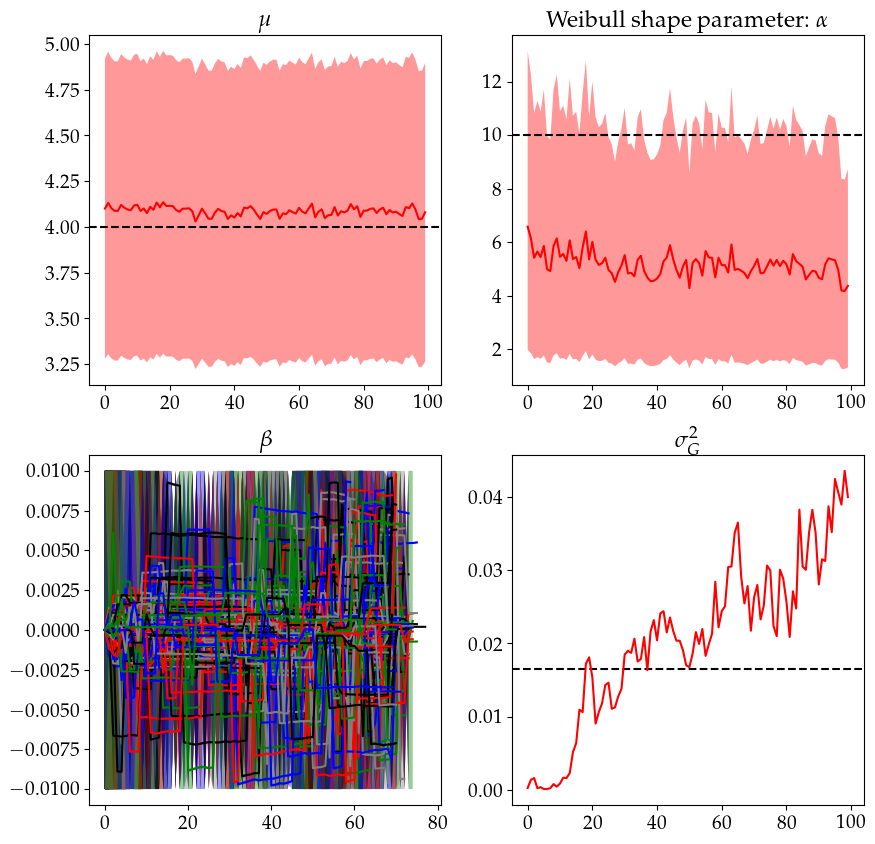

In [75]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
#plt.plot(np.repeat(pars["alpha"], 100))
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
#plt.ylim(-0.1, 0.1)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
sigma_g.plot_sampled_values(truth=sigma_g_true)
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

In [78]:
values, counts = np.unique(pars["mixture_component"], return_counts=True)

Mixture components

Text(0, 0.5, 'Number of markers')

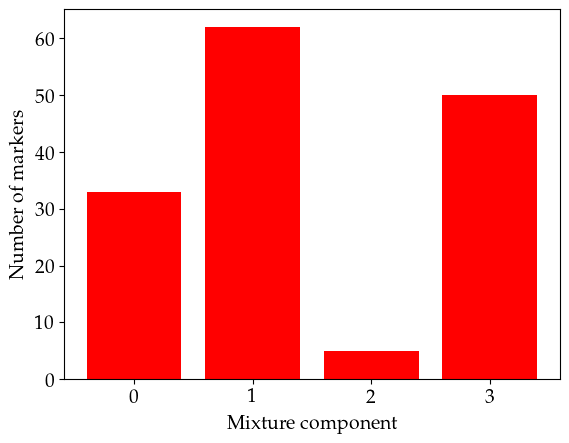

In [80]:
plt.bar(values, counts)
plt.xlabel("Mixture component")
plt.ylabel("Number of markers")

Here the mixture component seems quite arbitrary.

until here!

## Sampling with true sigmaG value

We init the paremters again and try with the true sigmaG

In [81]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                l_mix = 1, 
                                                data = data)

In [82]:
pars["sigma_g"] = sigma_g_true

In [84]:
pars["alpha"] = 0.5

In [85]:
maxit = 100
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.7, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

epsilon = y_data_log - mu.now

N = len(y_data_log)

for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))
    
    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        else:
            epsilon = epsilon + norm_markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - norm_markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
    

it: 1/100
it: 2/100
it: 3/100
it: 4/100
it: 5/100
5.228377654955783 (4.182702123964627, 6.274053185946939)


/home/avillanu/GitHub/BayesW/ars.py:168: RuntimeWarning: invalid value encountered in divide
  probs = probs/np.sum(probs)


ValueError: Something in the sampler went wrong

The error occurs because alpha is too big again

Text(0.5, 1.0, '$\\sigma_G^2$')

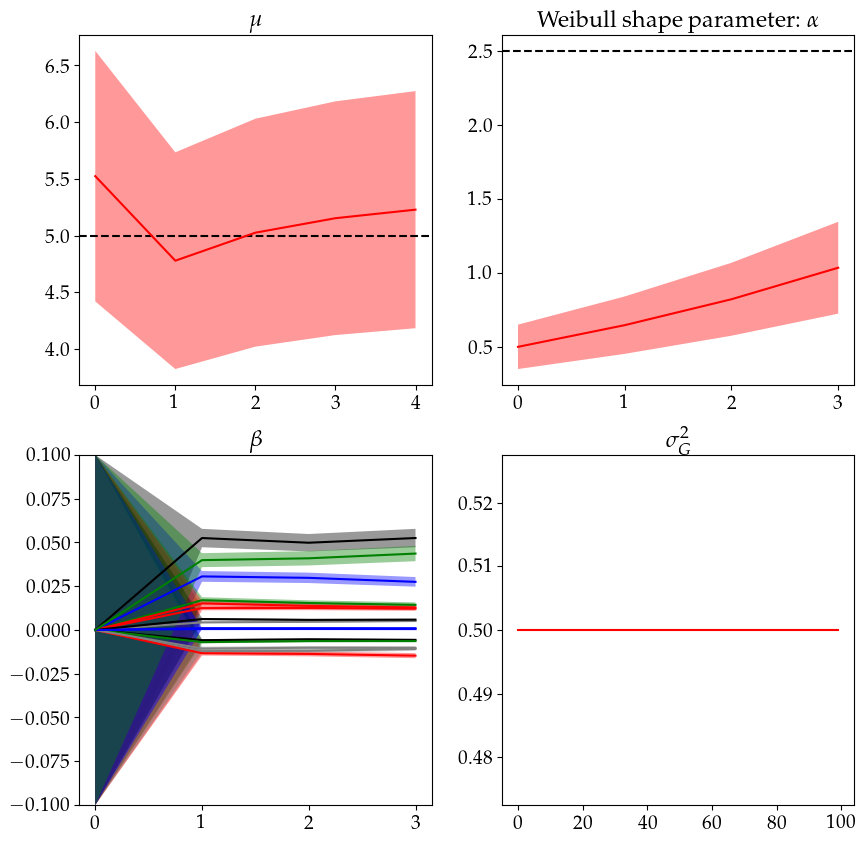

In [87]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
#plt.plot(np.repeat(pars["alpha"], 100))
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
plt.ylim(-0.1, 0.1)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
plt.plot(np.repeat(pars["sigma_g"], 100))
#sigma_g.plot_sampled_values()
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

Same case as before.

## Sampling all

In [88]:
pars, alpha_ini, sigma_g_ini = init_parameters(n_markers = n_markers,
                                                l_mix = 1, 
                                                data = data)

In [89]:
pars["sigma_g"]

0.4691988612383478

In [91]:
pars["alpha"] = 0.5

In [92]:
maxit = 100
mu = Parameter(log_mu, dev_log_mu, 
               bounds = (0.8,1.2), 
               init_value = np.mean(y_data_log))

alpha = Parameter(log_alpha, dev_log_alpha,
                  bounds = (0.7, 1.3),
                  init_value= pars["alpha"],
                  sampler_x0=0.1)

betas = list(np.zeros(n_markers))
for j in range(n_markers):
    betas[j] = Parameter(log_beta, dev_log_beta,
                bounds = (0.9, 1.1),
                init_value = 0)

sigma_g = SimpleParameter(pars["sigma_g"]) 
# i still have to work on this class but basically just samples the parameters with a close posterior

epsilon = y_data_log - mu.now

num_samples = 1

epsilon_array = [epsilon]
N = len(y_data_log)

for it in range(maxit):
    
    #clear_output(wait=False)
    print('it: {}/{}'.format(it+1,maxit))

    epsilon = epsilon + mu.now
    x = mu.sample_posterior(pars, epsilon)
    epsilon = epsilon - mu.now

    x = alpha.sample_posterior(pars, epsilon)
    pars["alpha"] = alpha.now

    exp_residuals = calculate_exp_epsilon(pars, epsilon)
    for j in range(n_markers):
        pars = prepare_pars_for_beta(pars, j)
        beta = betas[j]
        if beta.now == 0:
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        else:
            epsilon = epsilon + markers[:,j]*beta.now
            exp_residuals = calculate_exp_epsilon(pars, epsilon)
            partial_sums = compute_partial_sums(exp_residuals, markers[:,j])
        
        x = beta.sample_posterior(pars, partial_sums)

        epsilon = epsilon - markers[:,j]*beta.now
        exp_residuals = calculate_exp_epsilon(pars, epsilon)
    
    
    sigma_g.sample_posterior(sigma_g_func(betas, pars))
    pars["sigma_g"] = sigma_g.now

it: 1/100
it: 2/100
it: 3/100


/home/avillanu/GitHub/BayesW/ars.py:134: RuntimeWarning: overflow encountered in exp
  probs = np.exp(dhdxs * limits[:, 1] + c) - np.exp(dhdxs * limits[:, 0] + c)


it: 4/100
it: 5/100
5.136819891236726 (4.1094559129893815, 6.164183869484071)


/home/avillanu/GitHub/BayesW/ars.py:168: RuntimeWarning: invalid value encountered in divide
  probs = probs/np.sum(probs)


ValueError: Something in the sampler went wrong

Text(0.5, 1.0, '$\\sigma_G^2$')

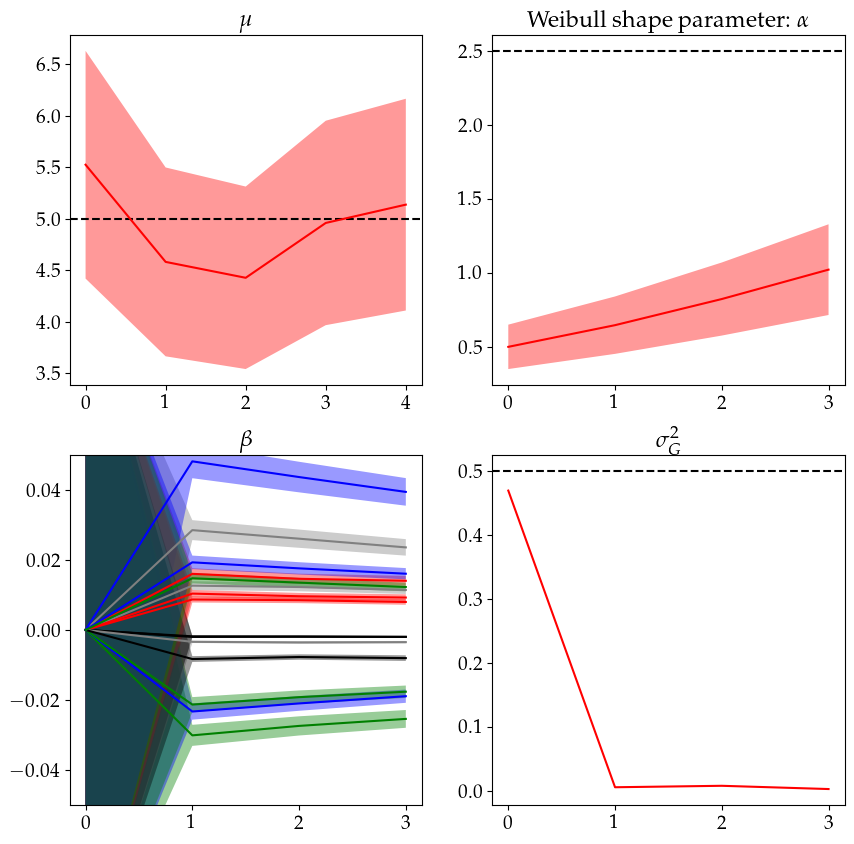

In [93]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
alpha.plot_sampled_values(truth = alpha_true)
plt.title(r"Weibull shape parameter: $\alpha$")

plt.subplot(2,2,1)
mu.plot_sampled_values(truth = mu_true)
plt.title(r"$\mu$")

plt.subplot(2,2,3)
for beta in betas:
    beta.plot_sampled_values()
plt.ylim(-0.05, 0.05)
plt.title(r"$\beta$")

plt.subplot(2,2,4)
sigma_g.plot_sampled_values(truth = sigma_g_true)
#plt.ylim(-0.05, 0.05)
plt.title(r"$\sigma_G^2$")

the sigma G goes to zero, so the betas go to zero. Again the alpha goes to values above one so the sampler stops.